In [1]:
!nvidia-smi | head -n 32

Sun Mar 11 12:32:28 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   33C    P0    59W / 250W |      0MiB / 11172MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:42:00.0 Off |                  N/A |
| 41%   73C    P2   218W / 250W |   9033MiB / 11172MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
        

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import sys
import os
sys.path.append('../common/')
import utils
import nets
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time
import random
plt.style.use('ggplot')
import traceback

In [2]:
MODEL_NAME = '3_11_rpn_cls'

In [3]:
#REMOTE_WORKER = "grpc://10.109.246.6:2222"
#cluster = tf.train.ClusterSpec({"local": ["10.109.246.6:2222"]})

In [4]:
import pickle
with open('../data/train_val.pkl','rb') as fhdl:
    (train_images,train_bbs,val_images,val_bbs) = pickle.load(fhdl)

In [5]:
BATCH_SIZE = 1

In [6]:
def rpn_layer(feature_map,k=9,ramda=10):
    mask_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,1 * k),name='mask_input')
    cls_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,k,2),name='cls_input')
    reg_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,k * 4),name='reg_input')
    
    with tf.variable_scope('rpn_conv'):
        rpn_hidden = tf.layers.conv2d(feature_map,filters=256,kernel_size=(3,3),padding='same',activation=tf.nn.relu,name='hidden')
        cls_result = tf.layers.conv2d(rpn_hidden,filters=2 * k,kernel_size=(1,1),padding='same',activation=None,name='cls_conv') # [BATCH_SIZE,None,None,4 * k]
        reg_result = tf.layers.conv2d(rpn_hidden,filters=4 * k,kernel_size=(1,1),padding='same',activation=None,name='reg_conv') # [BATCH_SIZE,None,None,4 * k]

    with tf.variable_scope('rpn_loss'):
        cls_input_reshape = tf.reshape(cls_input,shape=(-1,2))
        cls_result_reshape = tf.reshape(cls_result,shape=(-1,2))

        #reg_input_reshape = tf.reshape(reg_input,shape=(BATCH_SIZE,-1))
        #reg_result_reshape = tf.reshape(reg_result,shape=(BATCH_SIZE,-1))
        with tf.variable_scope('cls_loss'):
            cls_loss_unnorm = tf.losses.softmax_cross_entropy(onehot_labels=cls_input_reshape,logits=cls_result_reshape,reduction=tf.losses.Reduction.NONE)
            cls_loss_unnorm = tf.reshape(mask_input,shape=(-1,)) * cls_loss_unnorm
            cls_loss_unnorm = tf.reduce_sum(cls_loss_unnorm)
            cls_loss = cls_loss_unnorm / BATCH_SIZE
        
        with tf.variable_scope('reg_loss'):
            reg_loss_unnorm = tf.losses.huber_loss(labels=reg_input,predictions=reg_result,reduction=tf.losses.Reduction.NONE)
            reg_loss_unnorm = tf.reshape(reg_loss_unnorm,shape=(-1,4))
            reg_loss_unnorm = tf.reduce_sum(reg_loss_unnorm,axis=-1)
            print(reg_loss_unnorm.shape,cls_input_reshape[:,1].shape)
            regmask = cls_input_reshape[:,1]
            reg_loss_masked = tf.multiply(reg_loss_unnorm ,regmask)
            reg_loss_unnorm_sum = tf.reduce_sum(reg_loss_masked)
            reg_loss = 10 * reg_loss_unnorm_sum / (1e-5 + tf.reduce_sum(cls_input_reshape[:,1]))
        with tf.variable_scope('total_loss'):
            total_loss = cls_loss + reg_loss
        
    return cls_loss,reg_loss,total_loss,mask_input,cls_input,reg_input,cls_result,reg_result,reg_loss_unnorm,cls_input_reshape[:,1]

In [7]:
tf.reset_default_graph()

graph = tf.Graph()
with tf.device('/gpu:0'):
    with graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)
        global_step = tf.train.get_or_create_global_step()

        learning_rate = tf.placeholder(tf.float32) # 1e-3
        
        vgg_model = nets.VGG19(image_shape=(BATCH_SIZE,None,None,3),weights_dir='./vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
        input_image = vgg_model.input_tensor
        feature_map = tf.identity(vgg_model['block5_pool'], name='feature_map')
        with tf.variable_scope('RPN'):
            cls_loss,reg_loss,total_loss,mask_input,cls_input,reg_input,cls_result,reg_result,reg_loss_unnorm,tmask = rpn_layer(feature_map=feature_map)
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9,use_nesterov=True)
        train_op = optimizer.minimize(cls_loss,global_step=global_step)
        with tf.variable_scope('Train'):
            tf.summary.scalar('cls_loss',cls_loss)
            tf.summary.scalar('reg_loss',reg_loss)
            tf.summary.scalar('total_loss',total_loss)
        summary_op = tf.summary.merge_all()
        train_summary_writer = tf.summary.FileWriter("./log/compair/{}".format(MODEL_NAME), graph)
        
        with tf.variable_scope("Validation"):
            val_loss = tf.placeholder(tf.float32)
            val_loss_op = tf.summary.scalar("total_loss",val_loss)
            val_cls_loss = tf.placeholder(tf.float32)
            val_cls_op = tf.summary.scalar("cls_loss",val_cls_loss)
            val_reg_loss = tf.placeholder(tf.float32)
            val_reg_op = tf.summary.scalar("cls_loss",val_reg_loss)
        test_summary_op = tf.summary.merge([val_loss_op,val_cls_op,val_reg_op])

(?,) (?,)


In [8]:
with graph.as_default():
    #vgg_model.load_weights(sess)
    sess.run(tf.global_variables_initializer())
    vgg_model.load_weights(sess)
    sample_feature_map = sess.run(feature_map,feed_dict={input_image:np.ones(shape=(1,224,224,3))})

INFO:tensorflow:Restoring parameters from /tmp/tmpy4fsme0i


In [9]:
sample_feature_map.shape

(1, 7, 7, 512)

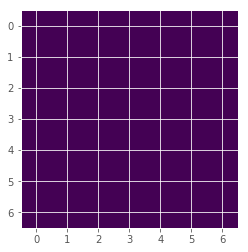

In [10]:
plt.imshow(sample_feature_map[0,:,:,0])

In [12]:
utils.show_graph(graph.as_graph_def())

In [11]:
with open('../data/training_data.pkl','rb') as fhdl:
    (out_train_image,out_train_bbs,out_train_imgsize,out_train_masks,out_train_cls_target,out_train_reg_target) = pickle.load(fhdl)

In [12]:
with open('../data/val_data.pkl','rb') as fhdl:
    (out_val_image,out_val_bbs,out_val_imgsize,out_val_masks,out_val_cls_target,out_val_reg_target) = pickle.load(fhdl)

In [13]:
box_tuple = [[16, 16],
 [32, 32],
 [48, 48],
 [64, 64],
 [96, 96],
 [128, 128],
 [192, 192],
 [256, 256],
 [512, 512]]

In [14]:
imgindex = random.randint(0,len(out_train_image))

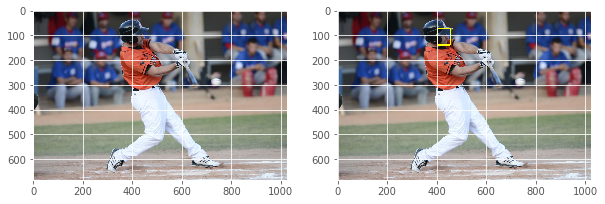

In [17]:
sample_image = plt.imread('../data/WIDER_train/images/{}'.format(out_train_image[imgindex]))
cls_target = out_train_cls_target[imgindex]
reg_target = out_train_reg_target[imgindex]
one_mask = out_train_masks[imgindex]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
for _,idx,idy,idbox in np.asarray(np.where(cls_target[:,:,:,:,1] == 1)).T:
    rx,ry = idx * 32 + 16,idy * 32 + 16
    boxw,boxh = box_tuple[idbox]
    w_delta,h_delta,w_rat,h_rat = reg_target[0,idx,idy,idbox]
    x_center = int(rx + boxw * w_delta)
    y_center = int(ry + boxh * h_delta)
    
    x_width = int(boxw * np.exp(w_rat))
    y_height = int(boxh * np.exp(h_rat))
    
    cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [18]:
print(sample_image.shape,cls_target.shape,reg_target.shape)

(684, 1024, 3) (1, 32, 21, 9, 2) (1, 32, 21, 9, 4)


In [19]:
768 // 32

24

In [20]:
np.sum(cls_target[:,:,:,:,1])

1.0

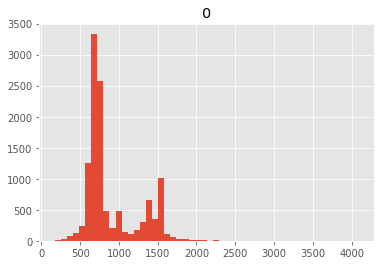

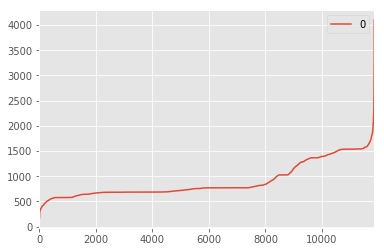

In [21]:
pd.DataFrame([i[0] for i in out_train_imgsize]).hist(bins=50)
pd.DataFrame(sorted([i[0] for i in out_train_imgsize])).plot()

In [15]:
class MultiIndex():
    def __init__(self,data):
        self.data = data
    def __getitem__(self,indexs):
        retval = []
        for i in indexs:
            retval.append(self.data[i])
        return retval
    @property
    def shape(self):
        return [len(self.data),]

In [16]:
mi = MultiIndex([1,2,3,4])
mi.shape,mi[[2,3]]

([4], [3, 4])

In [17]:
train_dataset = utils.Dataset(
    out_train_image,
    MultiIndex(out_train_masks),
    MultiIndex(out_train_cls_target),
    MultiIndex(out_train_reg_target))

In [18]:
one_imgurl,one_mask,cls_target,reg_target = train_dataset.next_batch(1)

In [19]:
one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]

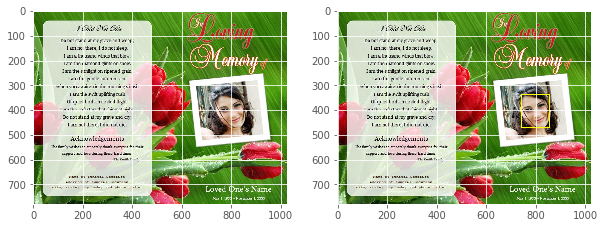

In [27]:

sample_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
for _,idx,idy,idbox in np.asarray(np.where(cls_target[:,:,:,:,1] == 1)).T:
    rx,ry = idx * 32 + 16,idy * 32 + 16
    boxw,boxh = box_tuple[idbox]
    w_delta,h_delta,w_rat,h_rat = reg_target[0,idx,idy,idbox]
    x_center = int(rx + boxw * w_delta)
    y_center = int(ry + boxh * h_delta)
    
    x_width = int(boxw * np.exp(w_rat))
    y_height = int(boxh * np.exp(h_rat))
    
    cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [28]:
sample_image.shape,one_mask.shape,cls_target.shape,reg_target.shape

((779, 1024, 3), (1, 32, 24, 9), (1, 32, 24, 9, 2), (1, 32, 24, 9, 4))

In [29]:
np.transpose(sample_image,[1,0,2]).shape

(1024, 779, 3)

In [20]:
if os.path.exists('models/{}'.format(MODEL_NAME)):
    print('dir exists')
else:
    os.mkdir('models/{}'.format(MODEL_NAME))

In [31]:
cls_target[:,:,:,:,1].shape

(1, 32, 24, 9)

In [32]:
np.copy(cls_target[:,:,:,:,1]).shape,one_mask.shape

((1, 32, 24, 9), (1, 32, 24, 9))

In [21]:
def add_random_spot(one_mask):
    one_mask_shape = one_mask.shape
    one_mask = one_mask.reshape(-1)
    if np.sum(one_mask) <= 8:
        num_addmask = 8
    else:
        num_addmask = int(min(np.sum(one_mask),len(one_mask) - np.sum(one_mask)))
    for i in range(num_addmask):
        one_mask[random.randint(0,len(one_mask) - 1)] = 1
    one_mask = one_mask.reshape(one_mask_shape)
    return one_mask

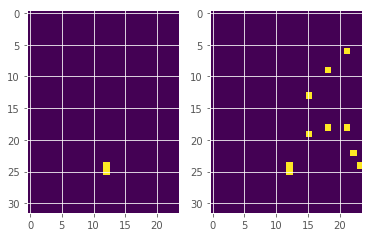

In [34]:
one_mask = np.copy(cls_target[:,:,:,:,1])
plt.subplot(1,2,1)
plt.imshow(np.sum(one_mask,-1)[0])
plt.subplot(1,2,2)
plt.imshow(np.sum(add_random_spot(one_mask),-1)[0])

In [35]:
reg_target.shape

(1, 32, 24, 9, 4)

In [36]:
cls_target.shape

(1, 32, 24, 9, 2)

In [22]:
32 * 54 * 9

15552

In [31]:
32 * 54 * 36 // 4

15552

In [33]:
with graph.as_default():
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(sess,"/data/icb/Faster-RCNN/training/models/3_9_rpn/model_2")

INFO:tensorflow:Restoring parameters from /data/icb/Faster-RCNN/training/models/3_9_rpn/model_2


In [35]:
EPOCHS = 10
BATCH_PER_EPOCH = len(train_images) // BATCH_SIZE
begining_learning_rate = 1e-6
decay_epoch = 5

for one_epoch in range(1,EPOCHS + 1):
    train_dataset = utils.Dataset(
    out_train_image,
    MultiIndex(out_train_masks),
    MultiIndex(out_train_cls_target),
    MultiIndex(out_train_reg_target))
    
    pb = utils.ProgressBar(worksum=BATCH_PER_EPOCH // 2)
    pb.startjob()
    for one_batch in range(1,BATCH_PER_EPOCH // 2 + 1):
        #one_imgurl,one_mask,cls_target,reg_target = train_dataset.next_batch(1)
        #one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
        #one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
        #if max(one_image.shape) > 2000:
        #    continue
        #one_image = np.transpose(one_image,[1,0,2])
        #one_image = np.expand_dims(one_image,0)
        
        try:
            batch_lr = begining_learning_rate * 0.5 ** (max(one_epoch - decay_epoch + 1,0))
            one_mask = np.copy(cls_target[:,:,:,:,1])
            one_mask = add_random_spot(one_mask)
            reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

            batch_train_summary_op,_,batch_cls_loss,batch_reg_loss,batch_total_loss,step_value = sess.run([summary_op,train_op,cls_loss,reg_loss,total_loss,global_step],feed_dict={
                learning_rate:batch_lr, 
                input_image:one_image,
                mask_input:one_mask,
                cls_input:cls_target,
                reg_input:reg_target
            })
            pb.info = "EPOCH {} BATCH {} lr {} cls_loss {:.2f} reg_loss {:.2f} total_loss {:.2f}".format(one_epoch,one_batch,
                    batch_lr,batch_cls_loss,batch_reg_loss,batch_total_loss)
            train_summary_writer.add_summary(batch_train_summary_op,step_value)
        except (KeyboardInterrupt,SystemExit):
            raise
        except:
            traceback.print_exc()
            break    
               
            
        pb.complete(1)
    with graph.as_default():
        saver = tf.train.Saver(tf.global_variables())
        saver.save(sess,"models/{}/model_{}".format(MODEL_NAME,one_epoch))
        

EPOCH 1 BATCH 70 lr 1e-06 cls_loss 7.75 reg_loss 0.40 total_loss 8.15 1.09 % [>--------------------------------------------------] 70/6440 	 used:20s eta:1894 s

KeyboardInterrupt: 

In [286]:
np.sum(np.sum(sess.run(reg_result,feed_dict={
            learning_rate:batch_lr,
            input_image:one_image,
            mask_input:one_mask,
            cls_input:cls_target,
            reg_input:reg_target
        }).reshape(-1,4),axis=-1) * cls_target[:,:,:,:,1].reshape(-1))

180.52725410461426

In [326]:
a = sess.run(reg_loss_unnorm,feed_dict={
            learning_rate:batch_lr,
            input_image:one_image,
            mask_input:one_mask,
            cls_input:cls_target,
            reg_input:reg_target
        })

In [329]:
sess.run(cls_loss,feed_dict={
            learning_rate:batch_lr,
            input_image:one_image,
            mask_input:one_mask,
            cls_input:cls_target,
            reg_input:reg_target
        })

144.69484

In [327]:
b = sess.run(tmask,feed_dict={
            learning_rate:batch_lr,
            input_image:one_image,
            mask_input:one_mask,
            cls_input:cls_target,
            reg_input:reg_target
        })

In [328]:
np.sum(a * b)

205.48979

In [248]:
np.expand_dims(one_image,0).shape

(1, 1024, 681, 3)

In [240]:
reg_target.reshape(list(reg_target.shape[:3]) + [-1,]).shape

(1, 32, 23, 36)

In [218]:
decay_epoch = 5
for one_epoch in range(1,10):
    print(1e-3 * 0.5 ** (max(one_epoch - decay_epoch + 1,0)))

0.001
0.001
0.001
0.001
0.0005
0.00025
0.000125
6.25e-05
3.125e-05
